# Imports

In [1]:
import sys
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

import cuqi
from cuqi.model import LinearModel
from cuqi.distribution import Gaussian, Posterior
from cuqi.problem import BayesianProblem
from cuqi.sampler import LinearRTO

from cuqi.implicitprior import RegularizedGaussian
from cuqi.sampler import RegularizedLinearRTO
from utils import *

In [2]:
# Set seed
np.random.seed(0)

In [3]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.8.0.post0.dev82


# Problem position

The goal of this notebook is to solve the inverse problem 

$$
y = Ax + n \ ,
$$

where $A$ is linear forward operator encoding a blur/convolution operation, $n$ is some additive noise with $n \sim \mathcal{N} (0, \sigma^2 I) $ and $y$ is the blurry observation of $y$.

**Goal:** Retrieve $x$ from $y$.

**Modelisation:**

- *Likelihood $P(Y|X=x)$:* Gaussian with density $p(y|X=x) \propto \exp (- \frac{1}{2\sigma^2} \| Ax - y\|_2^2)$.
- *Prior $P(X)$:* Gaussian with density $p(x) \propto \exp (- \frac{\gamma}{2} \| x\|_2^2)$.

It defines a posterior distribution $P(X|Y=y)$ with density $p(x|Y=y) \propto p(x) p(y|X=x)$.


**Method:** 

We propose to solve this inverse problem by sampling from a **regularized posterior distribution** $p_{reg} \propto p(x|Y=y) \exp ( -g(x))$, where $g$ is a regularizer that will promote solutions with expected properties described by $g$.



-   $\hat{y} = y + \sigma b_1$ with $b_1 \sim \mathcal{N}(0,  Id)$ <span style="color:red">(1)</span>
-   $\hat{c} = y + \frac{1}{\gamma} b_2$ with $b_2 \sim \mathcal{N}(0, Id)$  <span style="color:red">(2)</span>
-   $x = \operatorname{argmin}_u \frac{1}{2\sigma^2} \|Au - \hat{y} \|_2^2 + \frac{\gamma}{2} \|u - \hat{c} \|_2^2 + g(u) $ <span style="color:red">(3)</span>


The problem is that defining a good regularizer is complicated. The idea is to define the regularizer using a neural network denoiser $D_s$ such that $D_s = \operatorname{prox}_g^{\delta}$. 
We hope that it will infer some regularization from the data it has been trained on. 

To solve <span style="color:red">(3)</span> we will use the PnP-Forward-Backward algortihm which reads $x_{k+1} = \operatorname{prox}_g^{\delta} (x_k - \delta \nabla f(x_k) ) = D_s(x_k - \delta \nabla f(x_k) )$ with $\delta >0$ and $f$ the posterior potential.


# Experiments

## Groundtruth mage

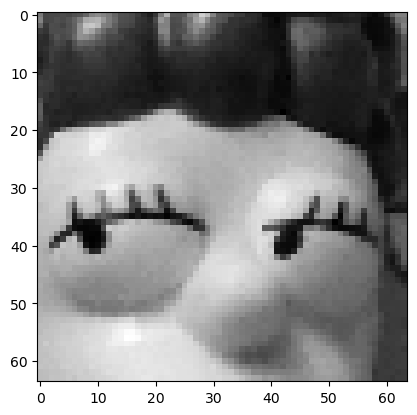

In [4]:
N = 64 # image size
l = 2 # box-filter kernel of size 2*l+1
lambd = 1000
sigma = np.sqrt(1/lambd) # standard deviation of the noise
gamma = 10 
sigma2 = sigma**2
gamma2 = gamma**2
device = "cuda:0"
# Loading the image
I = plt.imread("simpson_nb512.png")
im = I[2*N:3*N, N:2*N]
im /= np.max(im)

plt.figure()
plt.imshow(im, cmap = "gray")

## Define the Linear Operator with the CUQI framework

(-0.5, 63.5, 63.5, -0.5)

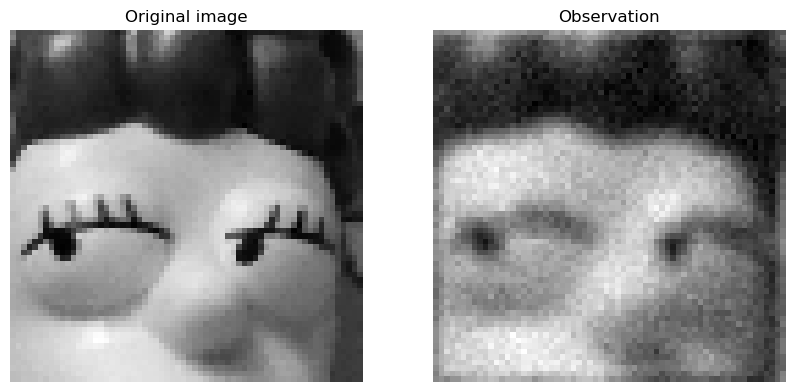

In [5]:
# Definition of the forward operator
l_k = 2*l + 1
h_ = np.ones((l_k, l_k))/(l_k)**2
k_uniform = np.zeros(im.shape)
k_uniform[0:l_k,0:l_k] = np.ones((l_k, l_k))/(l_k)**2
k_uniform = center_kernel(k_uniform, l)
h_fft = np.fft.fft2(k_uniform)
hc_fft = np.conj(h_fft)
A = lambda x : np.real(np.fft.ifft2(np.fft.fft2(x)*h_fft))
AT = lambda x : np.real(np.fft.ifft2(np.fft.fft2(x)*hc_fft))

# Specifying the geometry to match images
geometry = cuqi.geometry.Image2D((N,N)) # to work with 2D images
# CUQI linear operator
A_op = LinearModel(A, AT, range_geometry = geometry, domain_geometry = geometry)

# Observation
X_generation = Gaussian(0, gamma2, geometry = geometry) # need to specify a prior --> Gaussian as not informative as possible
Y_generation = Gaussian(A_op @ X_generation, sigma2, geometry = geometry)
y_data = Y_generation(X_generation = im).sample()

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(im, cmap = "gray")
ax1.axis("off")
ax1.set_title("Original image")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.reshape(y_data, (N, N)), cmap = "gray")
ax2.set_title("Observation")
ax2.axis("off")



### Loading the Plug-and-Play regularizer Fine with $s=2.25$

In [6]:
prior_denoiser = "fine" # "sn_dncnn" or "fine"
device = "cuda:0"
device = "cpu"
if prior_denoiser == "sn_dncnn":
    sys.path.append("./pnp_denoiser/sn_dncnn/")
    from ryu_utils.utils import load_model
    from denoiser import pytorch_denoiser_residual
    if device == "cpu":
        cuda = False
    else:
        cuda = True
    s = 5
    delta = 0.5/(1/sigma2 + 1/gamma2)
    model = load_model(model_type = "RealSN_DnCNN", sigma = s, device = device, cuda = cuda, path = "pnp_denoiser/sn_dncnn/Pretrained_models/")
    Ds = lambda x, z : pytorch_denoiser_residual(x, model, device)

elif prior_denoiser == "fine":
    # Firmly non-expansive network. 
    sys.path.append("./pnp_denoiser/sn_dncnn/")
    sys.path.append("./pnp_denoiser/fine/")
    from utils_terris_dncnn import load_dncnn_weights_2
    from denoiser import pytorch_denoiser
    if device == "cpu":
        cuda = False
    else:
        cuda = True
    s = 2.25
    n_ch = 1
    if s == 2.5:
        ljr = 0.005
    elif s == 2.25:
        ljr = 0.002
    delta = 0.5/(1/sigma2 + 1/gamma2)
    model = load_dncnn_weights_2(n_ch, s, ljr, device, path = 'pnp_denoiser/fine/ckpts/finetuned/')
    Ds = lambda x, delta : pytorch_denoiser(x, model, device)

### Bayesian problem formulation

In [9]:
geometry

Image2D(4096,)

In [12]:
# X  = ImplicitRegularizedGaussian(Gaussian(0, gamma2, geometry = geometry), proximal = Ds)
X = RegularizedGaussian(np.zeros(N*N), gamma2, proximal = Ds)
Y = Gaussian(A_op @ X, sigma2, geometry = geometry)
BP = BayesianProblem(Y, X).set_data(Y = y_data)
posterior = BP.posterior


sampler = RegularizedLinearRTO(posterior, maxit = 200, stepsize = delta, abstol=1e-10)
samples = sampler.sample(250, 0)

Sample 250 / 250


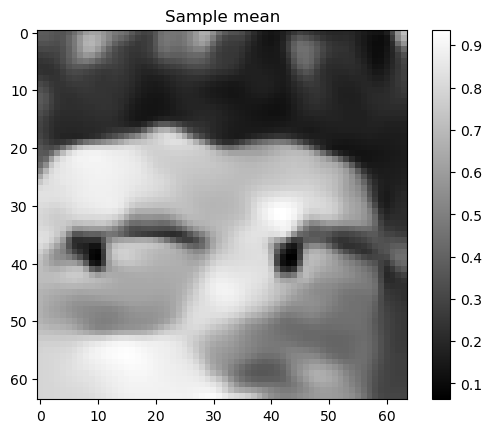

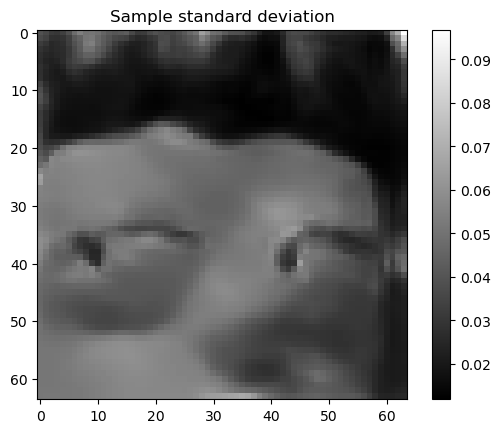

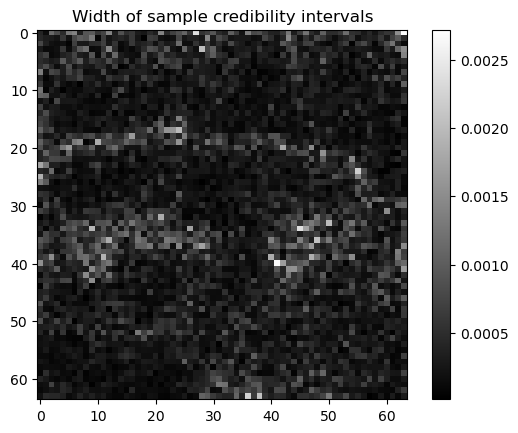

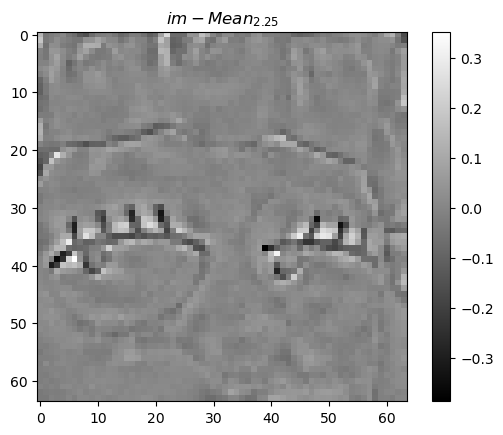

In [13]:
mean_225 = np.reshape(samples.mean(), (N, N))
std_225 = np.reshape(samples.std(), (N, N))

plt.figure()
IM_mean = samples.plot_mean()[0]
plt.colorbar(IM_mean)
plt.figure()
IM_std = samples.plot_std()[0]
plt.colorbar(IM_std)
plt.figure()
IM_ci = samples.plot_ci_width(0.95)[0]
plt.colorbar(IM_ci)

plt.figure()
plt.imshow(im - mean_225, cmap = 'gray')
plt.title(r"$im - Mean_{2.25}$")
plt.colorbar()

### Loading the PnP-Prior Fine with $s=2.5$

Sample 250 / 250


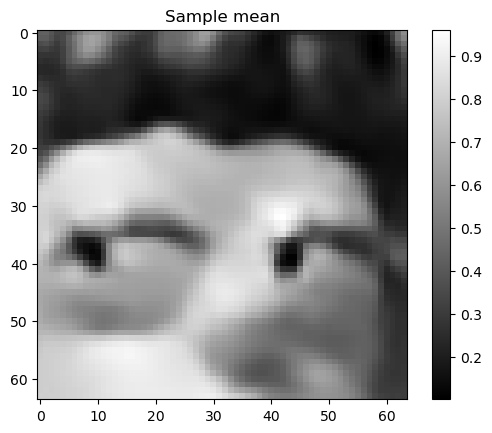

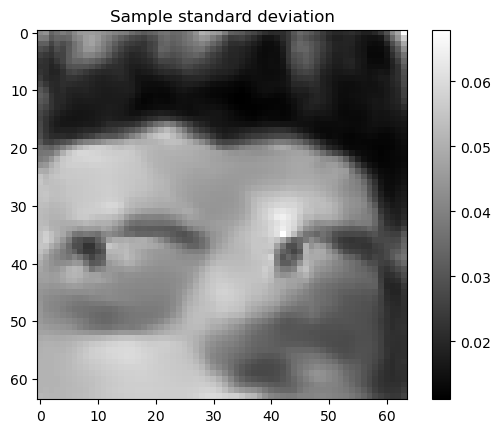

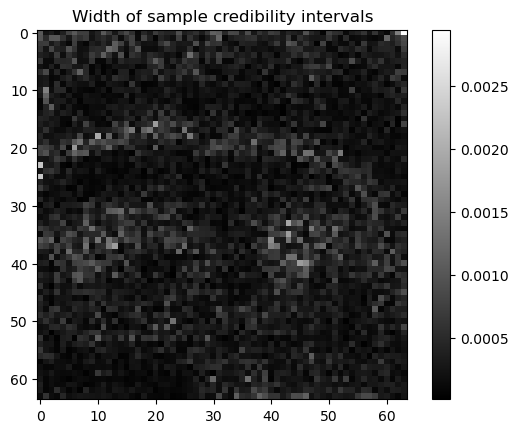

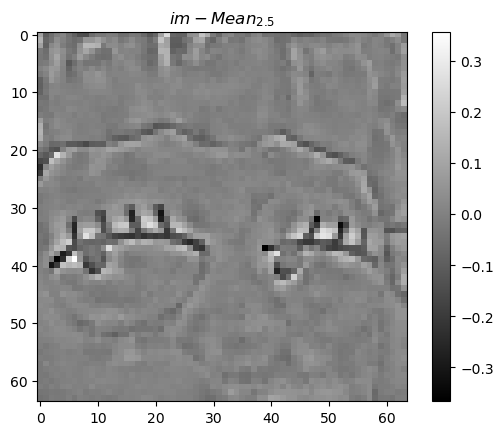

In [14]:
# Loading the model
sys.path.append("./pnp_denoiser/sn_dncnn/")
sys.path.append("./pnp_denoiser/fine/")
from utils_terris_dncnn import load_dncnn_weights_2
from denoiser import pytorch_denoiser
if device == "cpu":
    cuda = False
else:
    cuda = True
s = 2.5
n_ch = 1
if s == 2.5:
    ljr = 0.005
elif s == 2.25:
    ljr = 0.002
delta = 0.5/(1/sigma2 + 1/gamma2)
model = load_dncnn_weights_2(n_ch, s, ljr, device, path = 'pnp_denoiser/fine/ckpts/finetuned/')
# The function Ds makes the following conversion numpy vector --> pytorch (1, 1, N , N) --> numpy vector 
Ds = lambda x, delta : pytorch_denoiser(x, model, device) 

# Regularized distribtuion
# X  = ImplicitRegularizedGaussian(Gaussian(0, gamma2, geometry = geometry), proximal = Ds)
X = RegularizedGaussian(np.zeros(N*N), gamma2, proximal = Ds)
Y = Gaussian(A_op @ X, sigma2, geometry = geometry)
BP = BayesianProblem(Y, X).set_data(Y = y_data)
posterior = BP.posterior

# Sampling using the FBS algorithm
sampler = RegularizedLinearRTO(posterior, maxit = 200, stepsize = delta, abstol=1e-10)
samples = sampler.sample(250, 0)

# Results disply
mean_25 = np.reshape(samples.mean(), (N, N))
std_25 = np.reshape(samples.std(), (N, N))

plt.figure()
IM_mean = samples.plot_mean()[0]
plt.colorbar(IM_mean)
plt.figure()
IM_std = samples.plot_std()[0]
plt.colorbar(IM_std)
plt.figure()
IM_ci = samples.plot_ci_width(0.95)[0]
plt.colorbar(IM_ci)

plt.figure()
plt.imshow(im - mean_25, cmap = 'gray')
plt.title(r"$im - Mean_{2.5}$")
plt.colorbar()

Text(0.5, 1.0, '$Mean_{2.25} - Mean_{2.5}$')

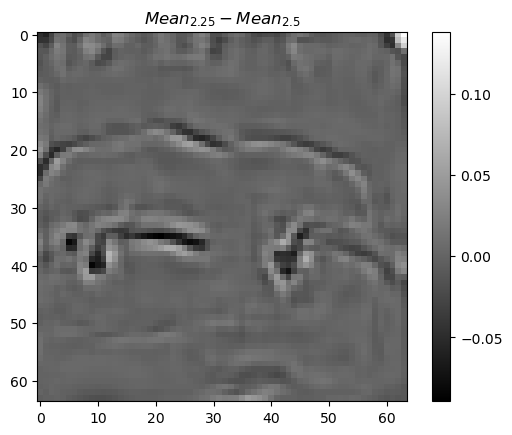

In [15]:
plt.figure()
plt.imshow(mean_225 - mean_25, cmap = 'gray')
plt.colorbar()
plt.title(r"$Mean_{2.25} - Mean_{2.5}$")

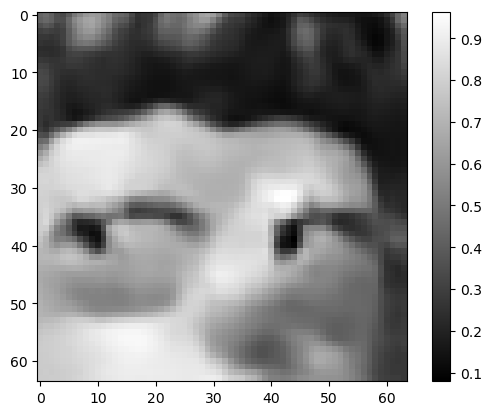

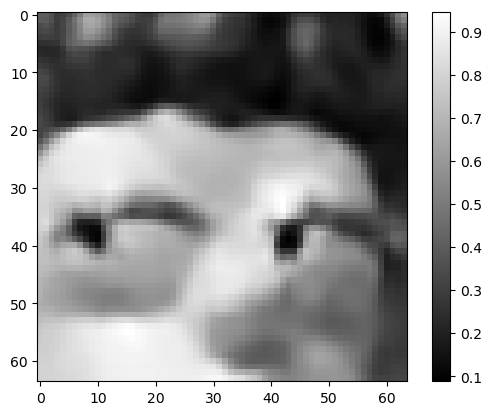

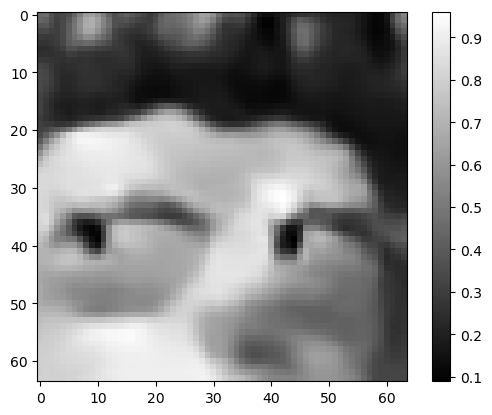

In [16]:
sample50 = samples.samples[:, 50]
sample150 = samples.samples[:, 150]
sample200 = samples.samples[:, 200]

plt.figure()
plt.imshow(np.reshape(sample50, (N, N)), cmap = "gray")
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(sample150, (N, N)), cmap = "gray")
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(sample200, (N, N)), cmap = "gray")
plt.colorbar()

# Conclusion

- Include MYULA within the CUQI framework in order to handle non-differentiable regularization for which we know the proximal operator.

$$
X_{k+1} = X_k - \delta \nabla f(X_k) - \frac{\delta}{s} (\operatorname{prox}_g^s (X_k) - X_k) + \sqrt{2\delta} Z_{k+1} 
$$

- Try with different denoisers.
